In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

altair    3.0.1
numpy     1.16.3
pandas    0.24.2
xarray    0.12.0



# 0. Utility functions

In [4]:
from utils.load import load_ko_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors)

# 1. Load the simulation data

In [5]:
ko_df, debug_info = load_ko_data()

In [6]:
ko_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.059225,ACALD,ACALD,Khodayari,fbaA,-0.059127
1,-0.004108,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,fbaA,-0.004101
2,0.000028,ACKr,ACKr,Khodayari,fbaA,0.000028
3,94.519769,ACONTa,ACONTa,Khodayari,fbaA,94.364274
4,94.276304,ACONTb,ACONTb,Khodayari,fbaA,94.121209


### Preprocess data

In [8]:
xdf = process_data(ko_df, author="Ishii")

# 2. Calculate error metrics

In [9]:
x_rel_error = relative_errors(xdf, author="Ishii")

In [10]:
x_norm_error = summary_errors(xdf, author="Ishii")

# 3. Visualize

### Summary normalized error for the models

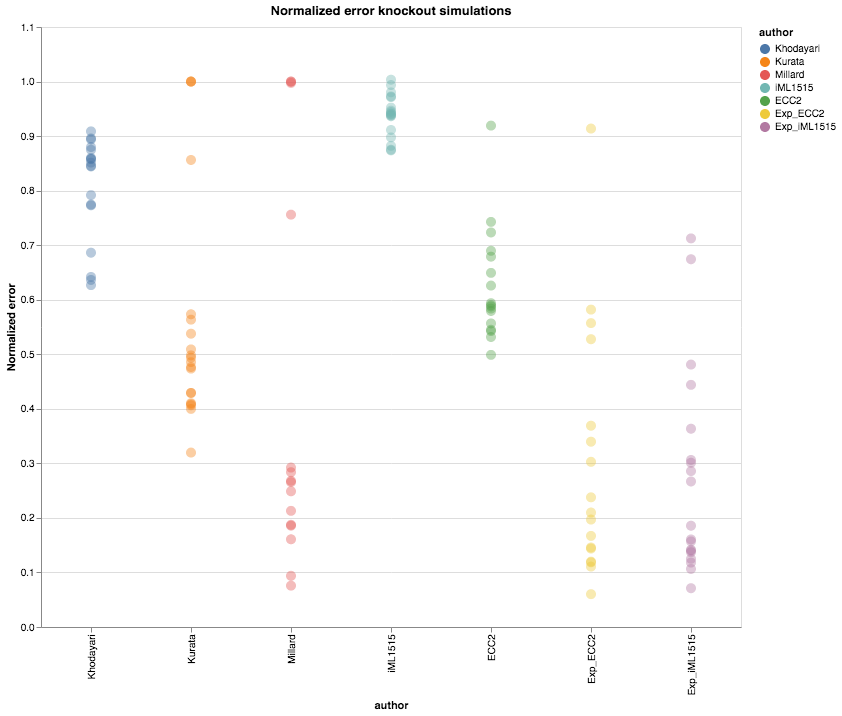

In [11]:
selector = alt.selection_single(empty="all", fields=["sample_id"])
color = alt.condition(
    selector,
    alt.Color(
        "author:N",
        sort=[
            "Khodayari",
            "Kurata",
            "Millard",
            "iML1515",
            "Ec_core",
            "ECC2",
            "Exp_ECC2",
        ],
    ),
    alt.ColorValue("lightgray"),
)

opacity = alt.condition(selector, alt.OpacityValue(0.4), alt.OpacityValue(1.0))

size = alt.condition(selector, alt.SizeValue(100), alt.SizeValue(40))


base = (
    alt.Chart(
        x_norm_error.to_dataframe()
        .reset_index()
        .query("author != 'Ishii'"),
        title="Normalized error knockout simulations",
    )
    .mark_circle()
    .encode(
        y=alt.Y("normalized_error", title="Normalized error"),
        tooltip=["author", "sample_id", "normalized_error"],
        x=alt.X("author", sort=["Khodayari", "Kurata", "Millard", "iML1515"]),
        size=size,
        opacity = opacity,
    )
)

errors = (
    base
    .encode(color=color)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

na_vals = base.encode(color=alt.value("lightgrey")).transform_filter("datum.normalized_error === null")


(errors).properties(width=700, height=600).configure_axis(
    labelFontSize=24, titleFontSize=24
).configure_legend(labelFontSize=16, titleFontSize=20).configure(invalidValues=None)


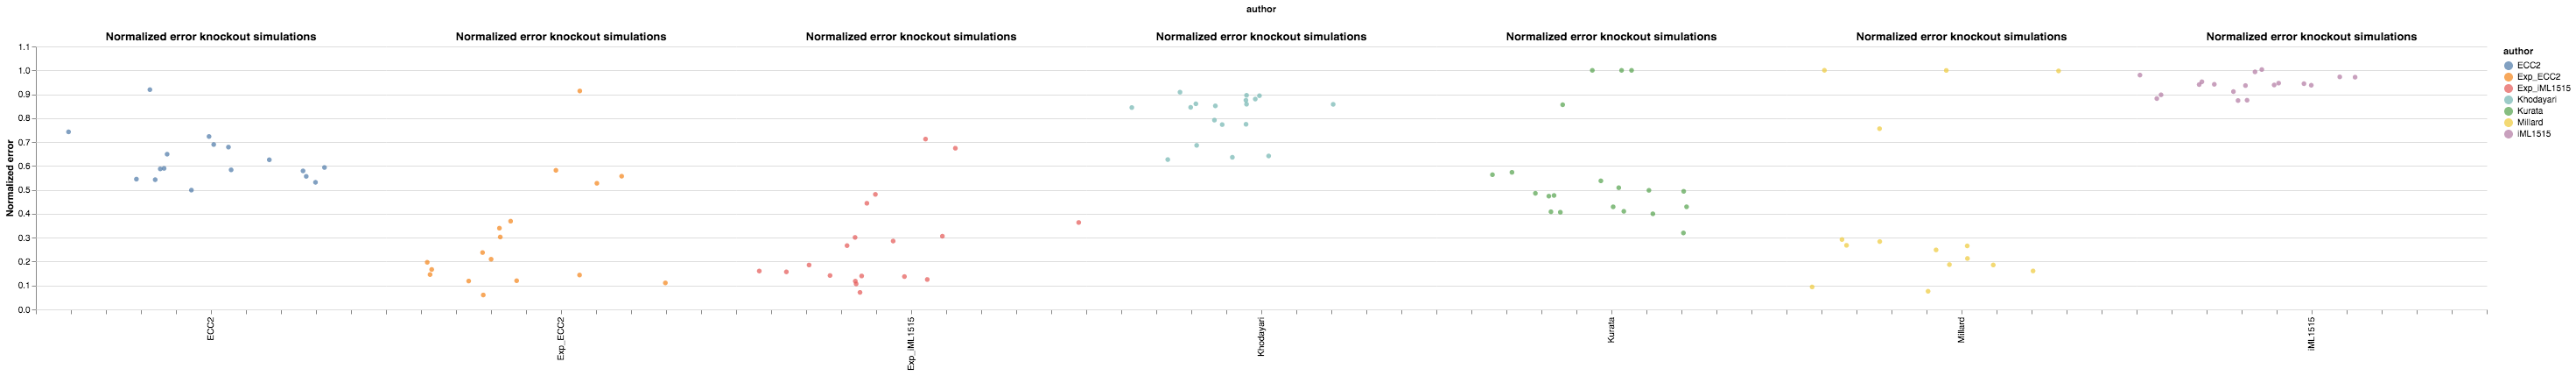

In [11]:
(
    alt.Chart(
        x_norm_error.to_dataframe()
        .reset_index()
        .query("author != 'Ishii' and author != 'Ec_core'"),
        title="Normalized error knockout simulations",
    )
    .mark_circle()
    .encode(
        y=alt.Y("normalized_error", title="Normalized error"),
        x=alt.X(
            "jitter:Q", title=None, axis=alt.Axis(grid=False, labels=False, ticks=True), scale=alt.Scale()
        ),
        color = alt.Color("author:N")
    )
    .transform_calculate(jitter="sqrt(-2*log(random()))*cos(2*PI*random())")
    .facet(column="author:N")
    .configure(facet=alt.CompositionConfig(spacing=0),
               view=alt.ViewConfig(stroke=None),
               header=alt.HeaderConfig(labelAlign=alt.Align("right"),
                labelAngle=-90,
                labelOrient=alt.Orient("bottom"),
                labelPadding=3,
                titleOrient=alt.Orient("top")))
)

In [12]:
def heatmap(xdf, author=None, sample_id=None):
    data = xdf['relative_error'].to_dataframe().reset_index()
    if sample_id:
        data = data.query(f"sample_id == '{sample_id}'")
        title = f"Heatmap for sample_id {sample_id}"
    else:
        data = data.query(f"author == '{author}'")
        title = f"Heatmap for author {author}"

    base = (
        alt.Chart(data, title=title)
        .mark_rect()
        .encode(
            y=alt.Y("BiGG_ID:N"),
            color=alt.condition(
                "datum.relative_error === null",
                alt.ColorValue("lightgrey"),
                alt.Color(
                    "relative_error",
                    scale=alt.Scale(
                        domain=[0, 25, 50, 75, 100, 200, 300], type="threshold", scheme="greenblue",
                    ),
                    title = "relative error (clipped at 300)"
                ),
            ),
            tooltip=["sample_id", "BiGG_ID", "relative_error"],
        )
    )
    if sample_id:
        chart = base.encode(x=alt.X("author:N"))
    else:
        chart = base.encode(x=alt.X("sample_id:N"))

    return chart.configure(invalidValues=None)

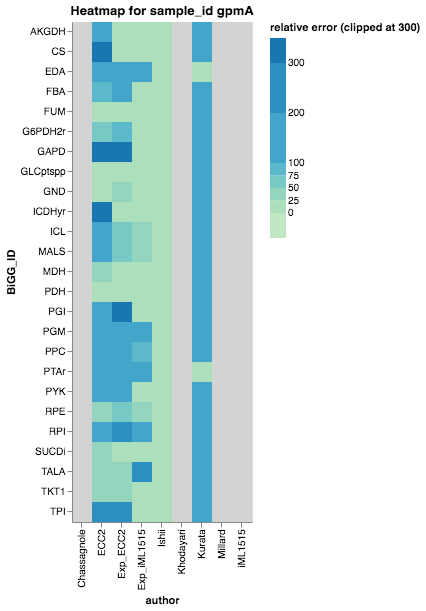

In [13]:
heatmap(x_rel_error, sample_id = "gpmA")

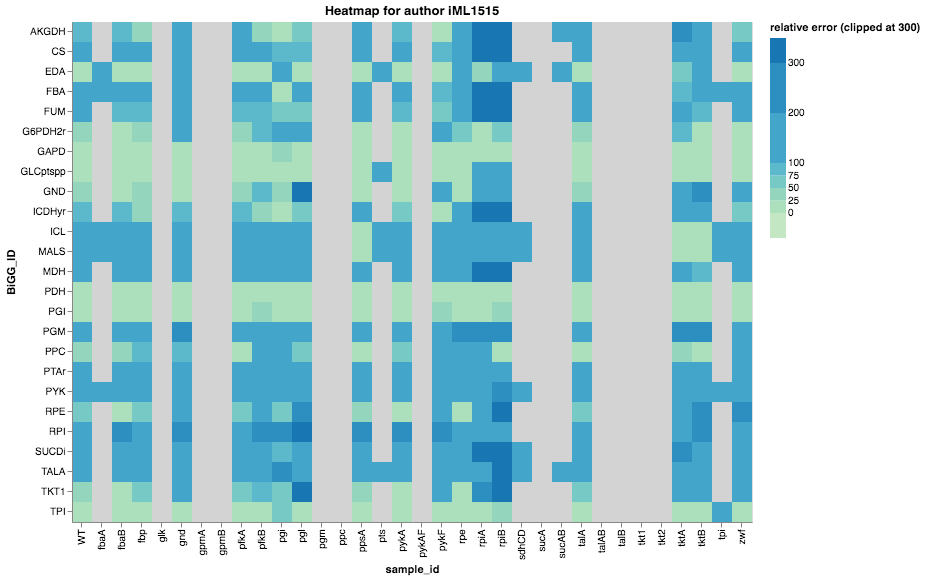

In [14]:
heatmap(xdf, author="iML1515")

# Export the data

In [42]:
path = data_path / "processed"
path.mkdir(parents=True, exist_ok=True)

In [201]:
x_rel_error.to_dataframe().reset_index().to_csv(data_path / "processed" / "ko_relative_errors.csv")

<xarray.Dataset>
Dimensions:          (BiGG_ID: 25, author: 11, sample_id: 22)
Coordinates:
  * sample_id        (sample_id) object 'WT' 'fbaB' 'fbp' ... 'tktB' 'zwf'
  * author           (author) object 'Chassagnole' 'ECC2' ... 'iML1515'
  * BiGG_ID          (BiGG_ID) object 'AKGDH' 'CS' 'EDA' ... 'TALA' 'TKT1' 'TPI'
Data variables:
    flux             (sample_id, author, BiGG_ID) float64 nan nan ... 2.676
    normalized_flux  (sample_id, author, BiGG_ID) float64 0.0 0.0 ... 93.16
    relative_error   (sample_id, author, BiGG_ID) float64 100.0 100.0 ... 0.1711

In [139]:
x_norm_error.to_dataframe().reset_index().to_csv(data_path / "processed" / "ko_summary_errors.csv")